In [1]:
from abc import ABC, abstractmethod

class ITextToImageGenerator(ABC):
    @abstractmethod
    def process(prompt: str, **kwargs):
        pass

In [2]:
from typing import Optional, Type


class TextToImageGeneratorFactory:
    default_strategy = "sdxl-turbo"
    strategy_map: dict[str, Type[ITextToImageGenerator]] = {}

    @classmethod
    def register(cls, name: str, generator_cls: Optional[ITextToImageGenerator]):
        if not issubclass(generator_cls, ITextToImageGenerator):
            raise TypeError(
                f"{generator_cls} must inherit from ITextToImageGenerator")
        cls.strategy_map[name] = generator_cls

    @classmethod
    def create(cls, name: str, **kwargs) -> ITextToImageGenerator:
        name = name or cls.default_strategy
        generator_cls = cls.strategy_map.get(name)
        if generator_cls is None:
            raise TypeError(f"No generator registered with name '{name}'")
        return generator_cls(**kwargs)


In [3]:
from typing import List, Optional

import torch
from diffusers import AutoPipelineForText2Image
from PIL import Image


class SDXLTurboGenerator(ITextToImageGenerator):
    def __init__(
        self,
        model_path: str = "stabilityai/sdxl-turbo",
        guidance_scale: float = 0.0,
        num_inference_steps: int = 4,
        device: str = "cuda",
        seed: int = 42,
        lora_path: Optional[str] = None,
    ):
        self.model_path = model_path
        self.guidance_scale = guidance_scale
        self.num_inference_steps = num_inference_steps
        self.device = device
        self.seed = seed
        self.lora_path = lora_path
        self.pipe = self._load_pipeline()

    def _load_pipeline(self):
        try:
            pipe = AutoPipelineForText2Image.from_pretrained(
                self.model_path, torch_dtype=torch.float16, variant="fp16"
            ).to(self.device)
            return pipe
        except Exception as e:
            raise ValueError(f"Failed to load pipeline: {e}") from e

    def process(
        self,
        prompt,
        num_images: int = 3,
        negative_prompt: str = "",
        height: int = 512,
        width: int = 512,
        **kwargs,
    ) -> List[Image.Image]:
        try:
            generator = torch.Generator("cuda")
            if self.seed is not None:
                generator.manual_seed(self.seed)

            outputs = self.pipe(
                prompt=prompt,
                num_images_per_prompt=num_images,
                negative_prompt=negative_prompt,
                height=height,
                width=width,
                num_inference_steps=self.num_inference_steps,
                guidance_scale=self.guidance_scale,
                generator=generator
            )
            return outputs.images
        except Exception as e:
            raise RuntimeError(f"Error in process(): {e}") from e


/home/anhndt/.conda/envs/pysvgenius/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import yaml
with open("/home/anhndt/pysvgenius/config/text2image.yaml", "r") as f:
    cfg = yaml.safe_load(f)

gen_cfg = cfg["sdxl-turbo"]
gen_cfg

{'model_path': 'stabilityai/sdxl-turbo',
 'guidance_scale': 0.0,
 'num_inference_steps': 1,
 'device': 'cuda',
 'seed': 1,
 'lora_path': None}

In [5]:
TextToImageGeneratorFactory.register("turbo", SDXLTurboGenerator)

In [6]:
generator = TextToImageGeneratorFactory.create("turbo", **gen_cfg)

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 10.95it/s]


In [23]:
image = generator.process("a beautifull dog", num_images=3, height=512, width=512)

100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


In [8]:
from IPython.display import display

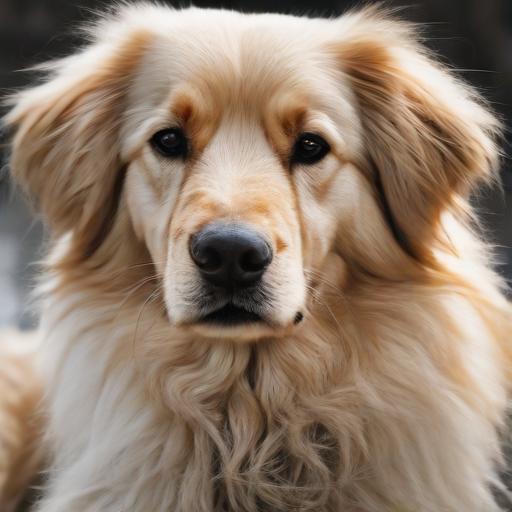

In [9]:
display(image[1])

In [10]:
from abc import ABC, abstractmethod
from PIL import Image
class IImageToConverter(ABC):
    @abstractmethod
    def process(self, images: list[Image.Image]):
        pass

In [11]:
from typing import Type


class ImageToConverterFactory:
    """
    A factory class for creating instances of image-to-SVG converters
    based on registered strategy names.

    This follows the Factory + Registry design pattern, allowing you to
    dynamically register and instantiate different implementations of
    IImageToConverter (e.g., Vtracer, Potrace, etc.).

    Attributes:
        default_strategy (str): The default converter strategy name used if none is specified.
        strategy_map (dict[str, Type[IImageToConverter]]): Mapping from strategy names to converter classes.
    """

    default_strategy: str = "vtracer"
    strategy_map: dict[str, Type[IImageToConverter]] = {}

    @classmethod
    def register(cls, name: str, converter_cls: Type[IImageToConverter]):
        """
        Register a new converter class under a given strategy name.

        Args:
            name (str): The strategy name to register (e.g., "vtracer").
            converter_cls (Type[IImageToConverter]): A class implementing the IImageToConverter interface.

        Raises:
            TypeError: If the provided class does not inherit from IImageToConverter.
        """
        if not issubclass(converter_cls, IImageToConverter):
            raise TypeError(
                f'{converter_cls} must inherit from IImageToConverter')
        cls.strategy_map[name] = converter_cls

    @classmethod
    def create(cls, name: str, **kwargs) -> IImageToConverter:
        """
        Create an instance of a registered image-to-converter strategy.

        Args:
            name (str): The name of the registered converter strategy to use.
                        If None or empty, the default strategy will be used.
            **kwargs: Additional keyword arguments passed to the converter's constructor.

        Returns:
            IImageToConverter: An instance of the requested converter class.

        Raises:
            TypeError: If no converter is registered under the provided name.
        """
        name = name or cls.default_strategy
        converter_cls = cls.strategy_map.get(name)
        if converter_cls is None:
            raise TypeError(f"No converter registered with name '{name}'")
        return converter_cls(**kwargs)


In [19]:
import re
import xml.etree.ElementTree as ET
from io import BytesIO
from itertools import product

import vtracer
from PIL import Image

from utils.image_utils import compute_ssim_images, resize_image
from utils.svg_utils import svg_to_png


class VtracerConverter(IImageToConverter):
    """
    A converter class that transforms raster images into optimized SVG vector graphics
    using vtracer with hyperparameter search and postprocessing.

    Attributes:
        default_svg (str): Fallback SVG content if conversion fails.
        max_size (int): Maximum allowed size (in bytes) for output SVG.
        speckle_values (list[int]): List of speckle filter values to sweep.
        layer_diff_values (list[int]): List of layer difference values to sweep.
        color_precision_values (list[int]): List of color precision values to sweep.
    """

    def __init__(self, max_size: int = 10000):
        """
        Initialize the converter with optional maximum SVG size.

        Args:
            max_size (int): Maximum allowed size for output SVG in bytes.
        """
        self.default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>"""
        self.max_size = max_size
        self.speckle_values = [10, 20, 40]
        self.layer_diff_values = [64, 128]
        self.color_precision_values = [4, 5, 6]

    def _postprocess_svg(self, svg_code: str) -> str:
        """
        Post-process the SVG string by removing unnecessary metadata.

        Operations include:
            - Removing the XML declaration line.
            - Removing the `version` attribute from the root <svg> tag.

        Args:
            svg_code (str): Raw SVG string generated by vtracer.

        Returns:
            str: Cleaned and minified SVG string.
        """
        ET.register_namespace("", "http://www.w3.org/2000/svg")
        tree = ET.ElementTree(ET.fromstring(svg_code))
        root = tree.getroot()

        if "version" in root.attrib:
            del root.attrib["version"]

        output = BytesIO()
        tree.write(output, encoding="utf-8", xml_declaration=True)
        result_svg = output.getvalue().decode("utf-8")

        result_svg = re.sub(r"<\?xml[^>]+\?>\s*", "", result_svg)

        return result_svg

    def _convert_image_to_svg(self, image: Image.Image) -> str:
        """
        Convert a single image to an SVG string by running vtracer with
        multiple hyperparameter combinations and selecting the best result
        based on SSIM similarity and file size constraints.

        Args:
            image (Image.Image): Input PIL image to be vectorized.

        Returns:
            str: Best matching SVG string after conversion and postprocessing.
        """
        best_ssim = -1
        best_svg = self.default_svg
        best_size = 0

        img_rgba = image.convert("RGBA")
        resized_img = resize_image(image=img_rgba, size=(384, 384))
        pixels = list(resized_img.getdata())

        for filter_speckle, layer_difference, color_precision in product(self.speckle_values, self.layer_diff_values, self.color_precision_values):
            svg_str = vtracer.convert_pixels_to_svg(
                rgba_pixels=pixels,
                size=resized_img.size,
                colormode="color",
                hierarchical="stacked",
                mode="polygon",
                filter_speckle=filter_speckle,
                color_precision=color_precision,
                layer_difference=layer_difference,
                corner_threshold=60,
                length_threshold=4.0,
                max_iterations=10,
                splice_threshold=45,
                path_precision=8,
            )

            ssim_score = compute_ssim_images(
                svg_to_png(svg_code=svg_str), image)

            byte_len = len(svg_str.encode("utf-8"))

            if byte_len <= self.max_size and byte_len > best_size:
                if best_ssim <= ssim_score:
                    best_ssim = ssim_score
                    best_svg = self._postprocess_svg(svg_str)
                    best_size = byte_len

        return best_svg

    def process(self, images: list[Image.Image]) -> list[str]:
        """
        Convert a list of PIL images to their corresponding optimized SVG strings.

        Args:
            images (list[Image.Image]): List of images to convert.

        Returns:
            list[str]: List of SVG strings corresponding to each input image.
        """
        result = []
        for image in images:
            output = self._convert_image_to_svg(image)
            result.append(output)

        return result

In [30]:
ImageToConverterFactory.register("vtracer", VtracerConverter)
converter = ImageToConverterFactory.create("vtracer", max_size=300000)
svg = converter.process(images=image)

In [31]:
from IPython.display import SVG, display

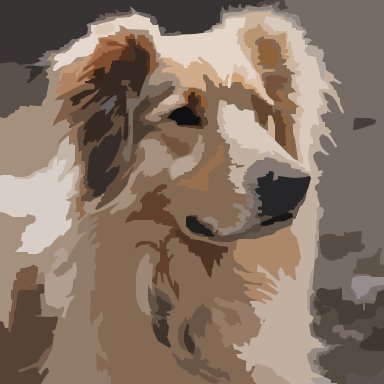

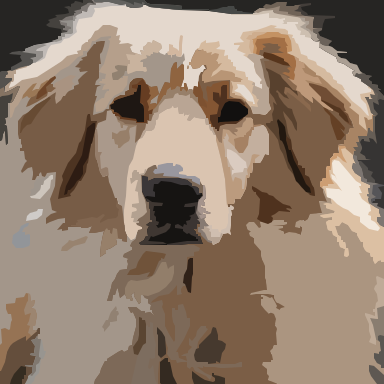

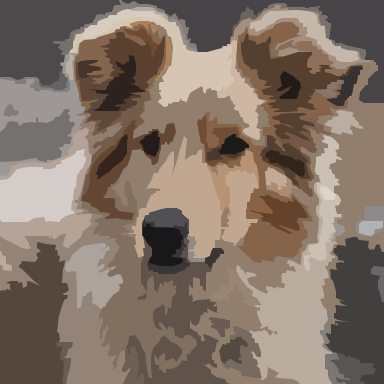

In [32]:
for svg_code in svg:
    display(SVG(svg_code))